In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import clone
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                             roc_auc_score, make_scorer, roc_curve)

In [4]:
Insurance_data = pd.read_csv(r"Data\health_insurance.csv")

Insurance_data = Insurance_data.drop(columns=['id'], axis=1)
Insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


In [5]:
# DataTransform func

def modelling_data(df, is_train=True, label='Response', scaler=None, encoders=None):

    df = df.copy()

    y = None
    if is_train and label in df.columns:
        y = df[label]
        df = df.drop(columns=[label])

    num_features = ['Age', 'Vintage', 'Annual_Premium']
    cat_features = ['Gender', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']

    if is_train:
        scaler = StandardScaler()
        df[num_features] = scaler.fit_transform(df[num_features])
    else:
        df[num_features] = scaler.transform(df[num_features])

    if is_train:
        encoders = {}
        for col in cat_features:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            encoders[col] = le
    else:
        for col in cat_features:
            df[col] = encoders[col].transform(df[col])

    if is_train:
        return df, y, scaler, encoders
    else:
        return df, scaler, encoders

In [6]:
# TrainEval func

def train_evaluate(model, X, y, cv_splits=5):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1': [],
        'roc_auc': []
    }
    
    for train_idx, val_idx in tqdm(skf.split(X, y), total=cv_splits, desc="Cross-validation"):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model_ = clone(model)
        
        model_.fit(X_train, y_train)

        y_pred = model_.predict(X_val)
        y_proba = model_.predict_proba(X_val)[:, 1]

        metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['recall'].append(recall_score(y_val, y_pred, zero_division=0))
        metrics['precision'].append(precision_score(y_val, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
        metrics['roc_auc'].append(roc_auc_score(y_val, y_proba))
    
    mean_scores = {m: np.mean(scores) for m, scores in metrics.items()}
    return pd.DataFrame(mean_scores, index=[model.__class__.__name__])


In [7]:
# TRAINING EXPERIMENT PIPELINE

X, y, scaler, encoders = modelling_data(Insurance_data, is_train=True)

# Adjusted_Weights for class imbalance
classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}

# Define models
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        class_weight=class_weight_dict,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.2,
        random_state=42,
        scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],
        eval_metric="auc",
        tree_method="hist"
    ),
    "CatBoost": CatBoostClassifier(
        iterations=1000,
        depth=8,
        learning_rate=0.05,
        random_state=42,
        auto_class_weights='Balanced',
        eval_metric='AUC',
        verbose=False
    )
}

In [8]:
# RUN MODELS EXPERIMENTS

print("Training RandomForest...")
rf_results = train_evaluate(models["RandomForest"], X, y)
display(rf_results)

Training RandomForest...


Cross-validation: 100%|██████████| 5/5 [03:21<00:00, 40.29s/it]


,accuracy,recall,precision,f1,roc_auc
RandomForestClassifier,0.693174,0.934083,0.277049,0.427345,0.854816


In [9]:
print("Training XGBoost...")
xgb_results = train_evaluate(models["XGBoost"], X, y)
display(xgb_results)

Training XGBoost...


Cross-validation: 100%|██████████| 5/5 [01:38<00:00, 19.73s/it]


,accuracy,recall,precision,f1,roc_auc
XGBClassifier,0.877437,0.0,0.0,0.0,0.856557


In [10]:
print("Training CatBoost...")
cat_results = train_evaluate(models["CatBoost"], X, y)
display(cat_results)

Training CatBoost...


Cross-validation: 100%|██████████| 5/5 [04:02<00:00, 48.53s/it]


,accuracy,recall,precision,f1,roc_auc
CatBoostClassifier,0.71631,0.904945,0.289626,0.438811,0.856912


In [15]:
# CATBOOST OPTIMIZATION

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna study objective func

def objective_cat(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.2),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 20),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 5.0),
        "border_count": trial.suggest_int("border_count", 32, 128),
        "eval_metric": "Logloss",
        "auto_class_weights": "Balanced",
        "verbose": False,
        "random_state": 42
    }

    model = CatBoostClassifier(**params)

    try:
        scores = cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
        mean_score = np.mean(scores)
        if np.isnan(mean_score):
            raise ValueError("NaN score encountered.")
        return mean_score

    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_cat, n_trials=30)

[I 2025-11-12 21:55:28,412] A new study created in memory with name: no-name-5be79d0f-8970-4f15-b6a2-dde96dd5f8ff
[I 2025-11-12 21:57:11,445] Trial 0 finished with value: 0.8564230016127347 and parameters: {'learning_rate': 0.08881879963579738, 'depth': 9, 'l2_leaf_reg': 5.098114586688451, 'bagging_temperature': 0.799020808617001, 'random_strength': 2.194680276894649, 'border_count': 72}. Best is trial 0 with value: 0.8564230016127347.
[I 2025-11-12 21:58:27,597] Trial 1 finished with value: 0.8585155038163667 and parameters: {'learning_rate': 0.10471319032822216, 'depth': 5, 'l2_leaf_reg': 14.836851281005062, 'bagging_temperature': 0.4928917740519001, 'random_strength': 1.2131321401438477, 'border_count': 83}. Best is trial 1 with value: 0.8585155038163667.
[I 2025-11-12 22:00:29,817] Trial 2 finished with value: 0.8566691769744763 and parameters: {'learning_rate': 0.06840298937599958, 'depth': 10, 'l2_leaf_reg': 19.537094927088678, 'bagging_temperature': 0.5453546522908878, 'random_s

In [17]:
print("Best CatBoost parameters:")
print(study.best_params)
print(f"Best AUC: {study.best_value:.4f}")

Best CatBoost parameters:
{'learning_rate': 0.10471319032822216, 'depth': 5, 'l2_leaf_reg': 14.836851281005062, 'bagging_temperature': 0.4928917740519001, 'random_strength': 1.2131321401438477, 'border_count': 83}
Best AUC: 0.8585


In [19]:
# BEST MODEL

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

catB_model = CatBoostClassifier(
    **study.best_params,
    iterations=1000,
    eval_metric="AUC",
    auto_class_weights="Balanced",
    verbose=200,
    random_state=42
    )

In [20]:
catB_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)


0:	test: 0.8218287	best: 0.8218287 (0)	total: 342ms	remaining: 5m 41s
200:	test: 0.8578770	best: 0.8578770 (200)	total: 9.28s	remaining: 36.9s
400:	test: 0.8583087	best: 0.8583531 (381)	total: 19.5s	remaining: 29.1s
600:	test: 0.8583316	best: 0.8584201 (526)	total: 28.1s	remaining: 18.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8584200845
bestIteration = 526

Shrink model to first 527 iterations.


In [31]:
y_val_proba = catB_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation ROC-AUC: {roc_auc:.5f}")

Validation ROC-AUC: 0.85842


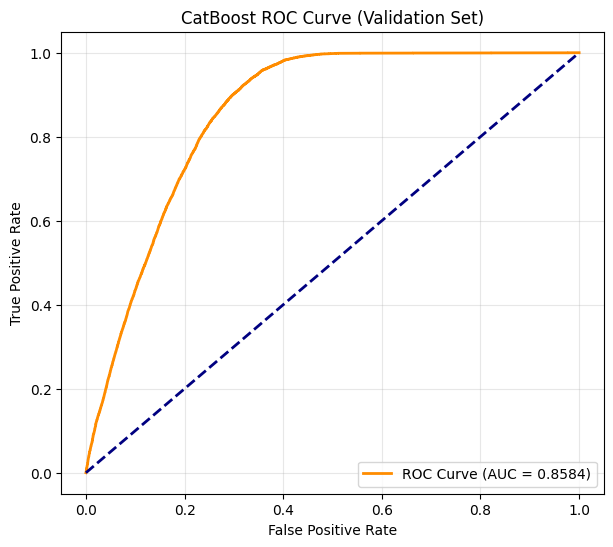

In [32]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve (Validation Set)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

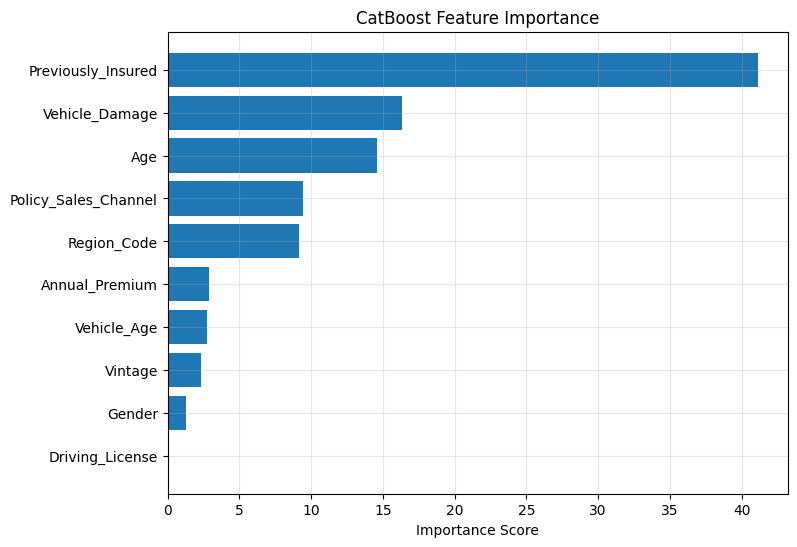

In [33]:
# Feature Importance
feature_importances = catB_model.get_feature_importance(prettified=True)

plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("CatBoost Feature Importance")
plt.grid(alpha=0.3)
plt.show()